# College Football Prediction Project
# Deep Learning models for College Football Game Prediction
by Nate Clause and John Vanderhoff
***

For background on the problem and prior models to solve the problem, see the "Prediction with Regression Models" notebook.

Recall that our Model 2 which takes in game stats and outputs the predicted score was highly accurate using a regression based approach. As a result, we will focus on utilizing deep learning for Models 1 and 3 only.
Recall that both Models 1 and 3 take in historical data for the teams in a given game and output the predicted stats and score, respectively, for this next game. One question is how big of an impact does a team's historical performance impact future performance, and at what time scale? For instance, it may turn out that the performance of only the past week or two is important, but perhaps the entire past year is all similarly important. As a result of these time-varying questions, we were motivated to use a long-short-term memory deep learning model for Models 1 and 3. In this notebook we will show the results of such modelling approaches.

## Model 1
Recall that in this model, we start with input the recent historical stats of each teams in a game and predict the stats for both teams in their pending matchup. 

In [1]:
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None 

In [2]:
games_df = pd.read_csv("clean_games_with_opp.csv", index_col=0)
games_df.reset_index(drop=True, inplace=True)
games_df.head()

,school,school_id,points,fumblesRecovered,rushingTDs,passingTDs,kickReturnYards,kickReturnTDs,kickReturns,kickingPoints,...,opposing_rushingTDs,opposing_points,side,thirdDownConverts,thirdDownAttempts,fourthDownConverts,fourthDownAttempts,completions,passAttempts,passCompletionPercentage
0,Navy,2426,17,0.0,2.0,0.0,64.0,0.0,4.0,5.0,...,1.0,34,A,4.0,12.0,1.0,1.0,2.0,4.0,0.500000
1,UAB,5,48,1.0,4.0,2.0,64.0,0.0,2.0,12.0,...,1.0,10,A,9.0,14.0,0.0,0.0,13.0,20.0,0.650000
2,UMass,113,7,0.0,0.0,1.0,95.0,0.0,4.0,1.0,...,2.0,30,A,3.0,11.0,1.0,1.0,9.0,22.0,0.409091
3,UCF,2116,24,1.0,2.0,1.0,142.0,0.0,5.0,6.0,...,1.0,26,A,5.0,13.0,2.0,2.0,12.0,22.0,0.545455
4,Houston,248,7,1.0,1.0,0.0,89.0,0.0,6.0,1.0,...,3.0,27,A,4.0,16.0,4.0,4.0,25.0,50.0,0.500000


We process out data that is missing or not in the desired numerical format.

In [3]:
# Dropping all columns with more than 25 nulls, then dropping the individual rows that have nulls
x = games_df.isna().sum().to_dict()
column_drop = []

for k, v in x.items():
    if v > 25 :
        column_drop.append(k)

# Additionally, these columns are weird formats or already covered by other variables (ie the possession stuff)
extend_list = ['completionAttempts','totalPenaltiesYards','possessionTime','possession_minutes','possession_seconds','year','week','school','opposing_points']

#column_drop.extend(extend_list)
column_drop = column_drop + extend_list

games_df.drop(columns=column_drop, inplace = True)
games_df.dropna(axis = 0, inplace = True)

games_df = games_df.select_dtypes(exclude=["object"])

games_df = games_df.sort_values("id")

We again set the memory (number of past games to remember) equal to 12, which roughly equates to 1 full season. We also extract the teams and put together a dictionary with keys each team and corresponding value all of their games in sorted chronological order.

In [4]:
memory = 12
teams = set(games_df["school_id"])

# Define a dictionary of the games for each team
teams_dict = {}
for team in teams:
    temp_df = games_df[games_df["school_id"] == team].sort_values("id")
    teams_dict[team] = temp_df.reset_index(drop=True)

In [5]:
X = []
y = []
points = []
for team in teams:
    team1_df = teams_dict[team]
    
    # loop over all possible games for a given team with enough prior games
    for i in range(memory, len(team1_df)):
        # find the two teams participating in the game
        game_id = team1_df.loc[i]["id"]
        both_teams_ids = games_df[games_df["id"] == game_id]["school_id"]
        both_teams_ids = list(both_teams_ids)

        # throw out some odd cases where  there was only data for one of the teams in a given game
        if len(both_teams_ids) != 2:
            continue
        #print(f"both teams are {both_teams_ids}")
 
        # extract the dataframes for the two teams, find which game it was for them
        t1_df = teams_dict[both_teams_ids[0]]#.loc[i-memory:i+1]
        t2_df = teams_dict[both_teams_ids[1]]#.loc[i-memory:i+1]

        t1_gamen = np.where(t1_df["id"] == game_id)[0][0]
        t2_gamen = np.where(t2_df["id"] == game_id)[0][0]

        # check to make sure that both teams have enough games in the past
        if t1_gamen < memory or t2_gamen < memory:
            continue
        
        # extract the games in recent history, dropping columns that don't go into the data
        t1_df = t1_df.loc[t1_gamen-memory:t1_gamen]#+1]
        t1_points = t1_df["points"].to_numpy()[-1]
        t2_df = t2_df.loc[t2_gamen-memory:t2_gamen]#+1]
        t2_points = t2_df["points"].to_numpy()[-1]
        t1_df.drop(columns=["id", "school_id", "points"], inplace=True)
        t2_df.drop(columns=["id", "school_id", "points"], inplace=True)

        t1_array = np.array(t1_df)
        t2_array = np.array(t2_df)

        # break the arrays into past games and current game to go into training and test set
        t1_past = t1_array[0:-1]
        t1_present = t1_array[-1]
        t2_past = t2_array[0:-1]
        t2_present = t2_array[-1]


        X.append(np.hstack([t1_past, t2_past]))
        y.append(np.hstack([t1_present, t2_present]))
        points.append(np.array([t1_points, t2_points]))
        
X = np.array(X)
y = np.array(y)
points = np.array(points)
print(X.shape, y.shape, points.shape)


(12742, 12, 56) (12742, 56) (12742, 2)


Now we scale the inputs. For Model 1 we scale the outputs as well to homogenize the impact of errors when analyzing model performance.

In [6]:

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Perform train-test split
X1_train, X1_test, y1_train, y1_test = train_test_split(X, y, test_size=0.25, random_state=42)

n_train_samples = len(X1_train)
n_test_samples = len(X1_test)

# Scale the inputs to the model
scaler = StandardScaler()
X1_train_flat = np.reshape(X1_train, (n_train_samples, -1))
X1_test_flat = np.reshape(X1_test, (n_test_samples, -1))
scaler.fit(X1_train_flat)
X1_train_scaled = scaler.transform(X1_train_flat)
X1_test_scaled = scaler.transform(X1_test_flat)
X1_train_scaled = np.reshape(X1_train_scaled, (n_train_samples, memory, -1))
X1_test_scaled = np.reshape(X1_test_scaled, (n_test_samples, memory, -1))

# Scale the outputs to the model
scaler2 = StandardScaler()
scaler2.fit(y1_train)
y1_train_scaled = scaler2.transform(y1_train)
y1_test_scaled = scaler2.transform(y1_test)


Now we initialize the Deep Learning model for Model 1. We will use a straightforward LSTM architecture with 3 LSTM layers followed by 1 dense layer. We settled on 3 layers because (1) this is a standard number in the literature, but more importantly (2) with some testing there was notable improvement from 2 to 3 layers, but not from 3 to 4.

In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM

# Initialize Model
model1 = Sequential()

# Add three LSTM layers with dropout, then a dense layer for the output
model1.add(LSTM(units=X.shape[2], return_sequences=True, input_shape=(X1_train_scaled.shape[1], X1_train_scaled.shape[2])))
model1.add(Dropout(0.2))

model1.add(LSTM(units=X.shape[2], return_sequences=True))
model1.add(Dropout(0.2))

model1.add(LSTM(units=X.shape[2]))
model1.add(Dropout(0.2))

model1.add(Dense(units=y.shape[1]))

# Print summary and compile 
model1.summary()
model1.compile(loss="mean_squared_error", optimizer="adam")




Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 12, 56)            25312     
                                                                 
 dropout (Dropout)           (None, 12, 56)            0         
                                                                 
 lstm_1 (LSTM)               (None, 12, 56)            25312     
                                                                 
 dropout_1 (Dropout)         (None, 12, 56)            0         
                                                                 
 lstm_2 (LSTM)               (None, 56)                25312     
                                                                 
 dropout_2 (Dropout)         (None, 56)                0         
                                                                 
 dense (Dense)               (None, 56)               

We now train the model:

In [8]:
from keras.callbacks import EarlyStopping

# Define a callback to stop early if fitting is no longer improving performance
callback = EarlyStopping(monitor='loss', patience=10)

# Fit model on training data
model1.fit(X1_train_scaled, y1_train_scaled, epochs=200, verbose=True, callbacks=[callback])

Epoch 1/200



299/299 [==============================] - 9s 13ms/step - loss: 0.9114
Epoch 2/200
299/299 [==============================] - 4s 13ms/step - loss: 0.8703
Epoch 3/200
299/299 [==============================] - 4s 13ms/step - loss: 0.8509
Epoch 4/200
299/299 [==============================] - 4s 12ms/step - loss: 0.8352
Epoch 5/200
299/299 [==============================] - 4s 13ms/step - loss: 0.8183
Epoch 6/200
299/299 [==============================] - 4s 13ms/step - loss: 0.7989
Epoch 7/200
299/299 [==============================] - 4s 12ms/step - loss: 0.7810
Epoch 8/200
299/299 [==============================] - 4s 13ms/step - loss: 0.7629
Epoch 9/200
299/299 [==============================] - 4s 13ms/step - loss: 0.7454
Epoch 10/200
299/299 [==============================] - 4s 13ms/step - loss: 0.7279
Epoch 11/200
299/299 [==============================] - 4s 13ms/step - loss: 0.7115
Epoch 12/200
299/299 [==============================] - 4s 12ms/step - loss: 0.6972
Epoch 13/200

Now we analyze the results:

In [9]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

y1_pred = model1.predict(X1_test_scaled)

print(f"MSE for Model 1 is: {mean_squared_error(y1_test_scaled, y1_pred)}")

100/100 [==============================] - 2s 5ms/step
MSE for Model 1 is: 0.5732190332907109


Recall that our best Regression model using Lasso Regression only achieved a MSE of ~0.84. Thus, there is a notable improvement with the Deep Learning approach. The more notable improvement however will come into play in Model 3:

## Model 3
We now generate and test the LSTM network for Model 3, which takes in historical stats of each team in a game and directly tries to predict the score of that game. We first perform out train-test split and scaling:

In [18]:
y3 = points

# Perform train test split
X3_train, X3_test, y3_train, y3_test = train_test_split(X, y3, test_size=0.25, random_state=42)

n_train_samples = len(X3_train)
n_test_samples = len(X3_test)

# Scale the inputs to the model
scaler = StandardScaler()
X3_train_flat = np.reshape(X3_train, (n_train_samples, -1))
X3_test_flat = np.reshape(X3_test, (n_test_samples, -1))
scaler.fit(X3_train_flat)
X3_train_scaled = scaler.transform(X3_train_flat)
X3_test_scaled = scaler.transform(X3_test_flat)
X3_train_scaled = np.reshape(X3_train_scaled, (n_train_samples, memory, -1))
X3_test_scaled = np.reshape(X3_test_scaled, (n_test_samples, memory, -1))

# Scale the outputs to the model
scaler2 = StandardScaler()
scaler2.fit(y3_train)
y3_train_scaled = scaler2.transform(y3_train)
y3_test_scaled = scaler2.transform(y3_test)

Note that we scaled the outputs to Model 3 (score), which we did not do with our linear regression approaches. In the linear regression approaches, scaling the outputs did not have any real impact on the results, whereas in our deep learning approach we found that scaling the outputs and then inverting the scaling consistently lead to *at least* 10% better performance.

In [33]:
# Define y3 to be the points array
y3 = points

# Construct the three-layer model
model3 = Sequential()

model3.add(LSTM(units=X.shape[2], return_sequences=True, input_shape=(X3_train_scaled.shape[1], X3_train_scaled.shape[2])))
#model3.add(Dropout(0.2))

model3.add(LSTM(units=X.shape[2], return_sequences=True))
#model3.add(Dropout(0.2))

model3.add(LSTM(units=X.shape[2]))
#model3.add(Dropout(0.2))

model3.add(Dense(units=y3.shape[1]))

model3.summary()

# Recall for the scores we want MAE instead of MSE
model3.compile(loss="mean_squared_error", optimizer="adam")

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 12, 56)            25312     
                                                                 
 lstm_13 (LSTM)              (None, 12, 56)            25312     
                                                                 
 lstm_14 (LSTM)              (None, 56)                25312     
                                                                 
 dense_4 (Dense)             (None, 2)                 114       
                                                                 
Total params: 76050 (297.07 KB)
Trainable params: 76050 (297.07 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [34]:
model3.fit(X3_train_scaled, y3_train_scaled, epochs=200, verbose=True)

Epoch 1/200
299/299 [==============================] - 8s 12ms/step - loss: 0.7857
Epoch 2/200
299/299 [==============================] - 4s 12ms/step - loss: 0.7241
Epoch 3/200
299/299 [==============================] - 4s 12ms/step - loss: 0.6776
Epoch 4/200
299/299 [==============================] - 4s 12ms/step - loss: 0.6178
Epoch 5/200
299/299 [==============================] - 4s 12ms/step - loss: 0.5470
Epoch 6/200
299/299 [==============================] - 4s 12ms/step - loss: 0.4672
Epoch 7/200
299/299 [==============================] - 4s 12ms/step - loss: 0.3952
Epoch 8/200
299/299 [==============================] - 4s 12ms/step - loss: 0.3277
Epoch 9/200
299/299 [==============================] - 4s 12ms/step - loss: 0.2714
Epoch 10/200
299/299 [==============================] - 4s 12ms/step - loss: 0.2201
Epoch 11/200
299/299 [==============================] - 4s 12ms/step - loss: 0.1783
Epoch 12/200
299/299 [==============================] - 4s 12ms/step - loss: 0.1426
E

Now we analyze the results:

In [35]:
y3_pred_scaled = model3.predict(X3_test_scaled)
y3_pred = scaler2.inverse_transform(y3_pred_scaled)

print(f"MAE for Model 3 is: {mean_absolute_error(y3_test, y3_pred)}")

100/100 [==============================] - 1s 5ms/step
MAE for Model 3 is: 3.4470501895190075


The mean absolute error of ~3.45 points away in score is much better than the >9 points mean absolute error we saw with classical regression techniques.

We see how accurate the model was in predicting the winner of a given game:

In [36]:
real_games = []
pred_games = []
for i in range(len(y3_test)):
    # determine which models predicted team 1 to win
    if y3_test[i][0] > y3_test[i][1]:
        real_games.append(1)
    else:
        real_games.append(0)

    if y3_pred[i][0] > y3_pred[i][1]:
        pred_games.append(1)
    else:
        pred_games.append(0)
    
# Sum up the number of times the model predicted the wrong winner
incorrect_games = np.sum(np.abs(np.array(pred_games) - np.array(real_games)))
correct_games = len(y3_test) - incorrect_games

print(f"Correct games is: {correct_games} out of {len(y3_test)}, pct correct is {(correct_games)/len(y3_test)}.")

Correct games is: 2884 out of 3186, pct correct is 0.9052102950408035.


So our model is correctly predicting the winner in approximately 90.5% of the games. According to https://philsteele.com/how-often-to-underdogs-win-outright/, over a similar timeframe the underdog (according to Las Vegas sportsbook betting lines) won the game ~76.7% of the time. Thus, a correct prediction rate of ~90.5% is quite good. A future line of inquiry is to gather data on the spread for each game and compare our results against the spread, by comparing the difference from the Vegas spread to the real spread vs the difference from our predicted spread vs the real spread.

In [37]:
model_residuals = y3_test - y3_pred

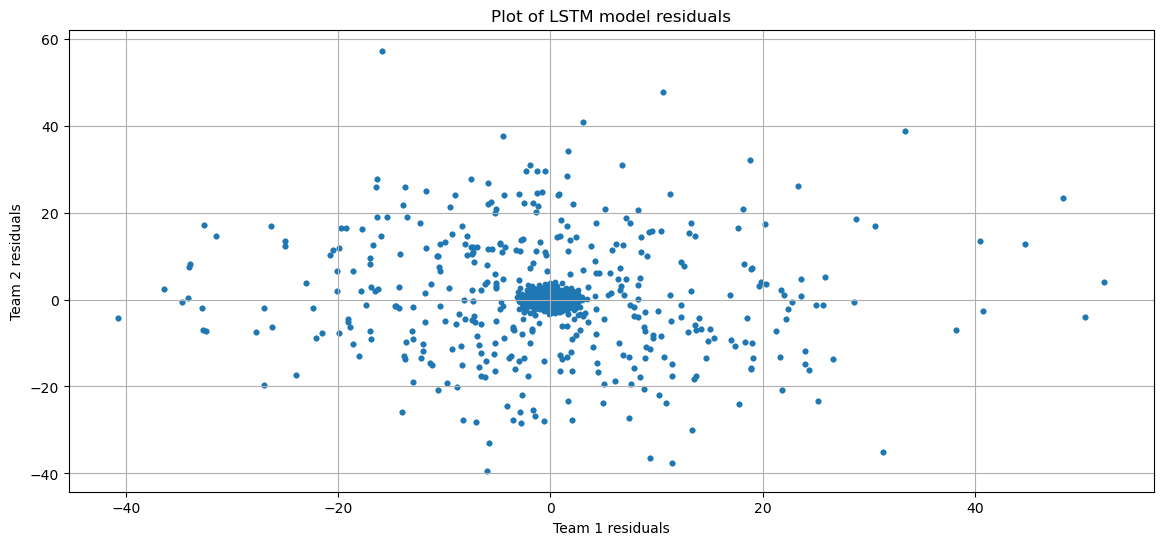

In [38]:
import matplotlib.pyplot as plt

# Plotting residuals
plt.figure(figsize=(14,6))

plt.scatter(x = model_residuals[:,0], y = model_residuals[:,1], s=10)
plt.title('Plot of LSTM model residuals')
plt.xlabel('Team 1 residuals')
plt.ylabel('Team 2 residuals')
plt.grid()
plt.show()

Note that in extremal cases, this model has outliers on the same magnitude as our LassoCV model. That said, the majority of the data is clustered much more closely to the center, indicitave of the fact that for the vast majority of the games, the new model's predictions are notably better.

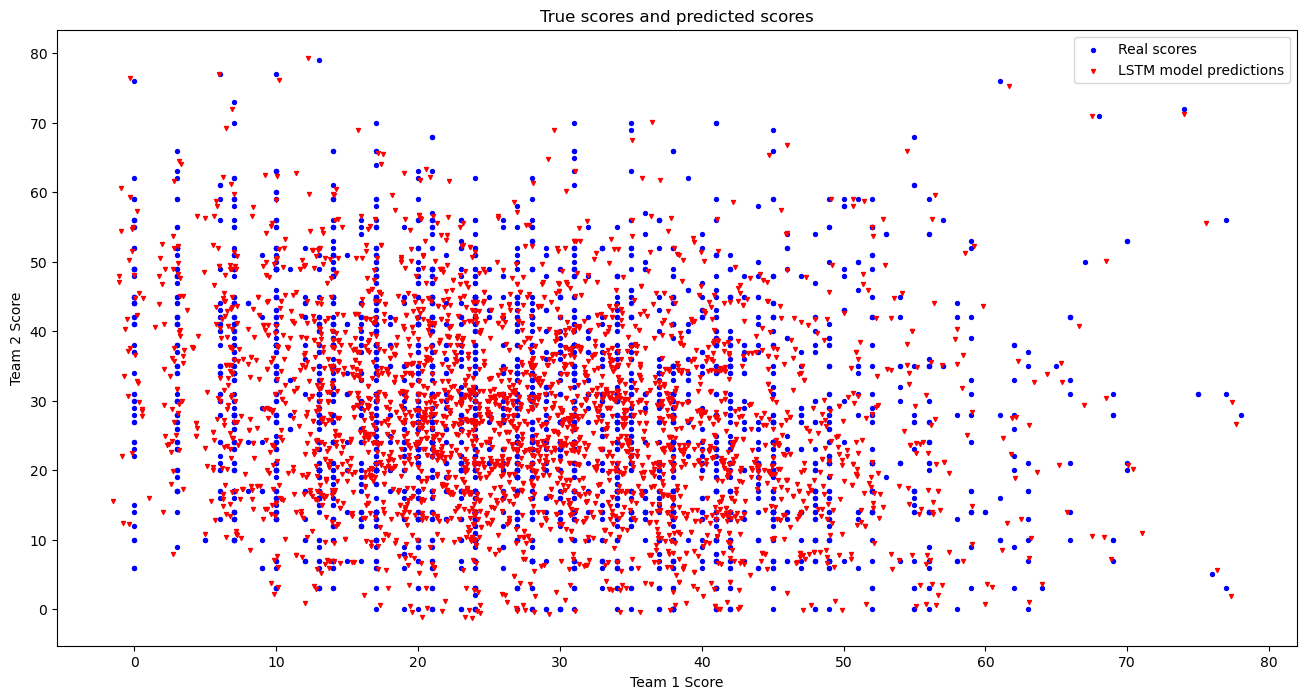

In [39]:
fig = plt.figure(figsize=(16,8))
ax1 = fig.add_subplot(111)

ax1.scatter(y3_test[:,0], y3_test[:,1], s=8, c='b', marker="o", label='Real scores')
ax1.scatter(y3_pred[:,0], y3_pred[:,1], s=8, c='r', marker="v", label='LSTM model predictions')

plt.legend(loc='upper right')
plt.xlabel('Team 1 Score')
plt.ylabel('Team 2 Score')
plt.title('True scores and predicted scores')
plt.show()